In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [3]:
tickers = ['AAPL', 'GOOGL', 'AMZN', 'JPM', 'KO']

# Download only 'Close' prices to avoid shape errors
data = yf.download(tickers, start="2020-06-01", end="2023-06-01")['Close']
data = data.dropna()
data.head()


C:\Users\HP\AppData\Local\Temp\ipykernel_21736\3537947199.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-06-01", end="2023-06-01")['Close']
[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,JPM,KO
Date,,,,,
2020-06-01,78.215103,123.552002,71.315796,85.798080,40.014393
2020-06-02,78.577217,123.620499,71.685577,86.085236,39.937752
2020-06-03,79.009781,123.919998,71.533485,90.731880,40.789307
2020-06-04,78.329315,123.029999,70.293419,92.620148,40.806335
2020-06-05,80.560234,124.150002,71.571747,96.788246,41.802654


In [4]:
np.random.seed(42)

mean_daily_returns = data.pct_change().mean()
cov_matrix = data.pct_change().cov()

num_portfolios = 10000
all_weights = []
returns_list = []
volatility_list = []
sharpe_list = []

for _ in range(num_portfolios):
    weights = np.random.random(len(data.columns))
    weights /= np.sum(weights)

    all_weights.append(weights)

    port_return = np.sum(mean_daily_returns * weights) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = port_return / port_volatility

    returns_list.append(port_return)
    volatility_list.append(port_volatility)
    sharpe_list.append(sharpe_ratio)

results_df = pd.DataFrame({
    'Return': returns_list,
    'Volatility': volatility_list,
    'Sharpe Ratio': sharpe_list,
    'Weights': all_weights
})

best_index = results_df['Sharpe Ratio'].idxmax()
best_portfolio = results_df.loc[best_index]


In [5]:
for stock, weight in zip(tickers, best_portfolio['Weights']):
    print(f"{stock}: {weight:.2%}")


AAPL: 47.81%
GOOGL: 0.46%
AMZN: 7.60%
JPM: 16.47%
KO: 27.66%


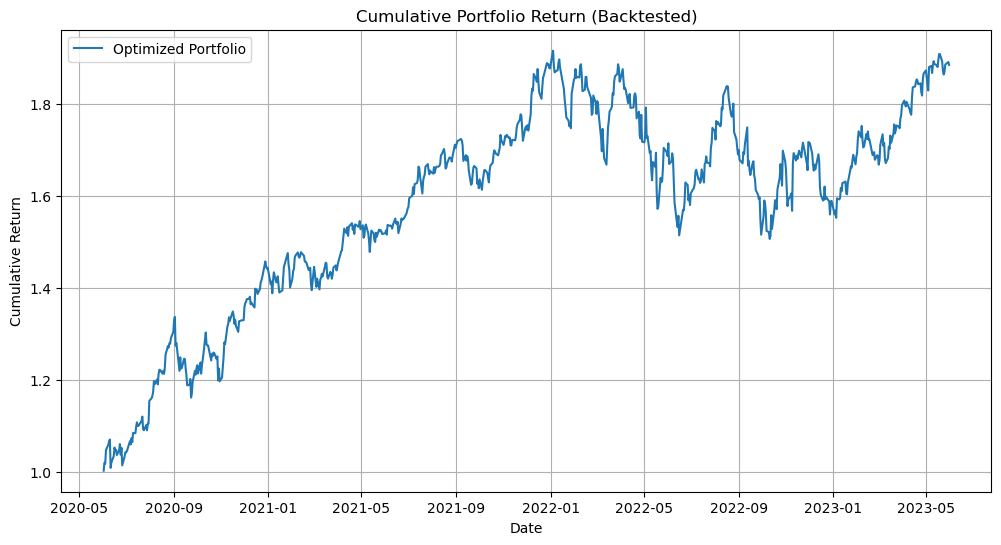

In [6]:
# Step 1: Calculate daily returns
returns = data.pct_change().dropna()

# Step 2: Apply weights to returns
weights = np.array(best_portfolio['Weights'])
weighted_returns = returns.mul(weights, axis=1)

# Step 3: Daily portfolio return
portfolio_returns = weighted_returns.sum(axis=1)

# Step 4: Cumulative portfolio return
cumulative_returns = (1 + portfolio_returns).cumprod()

# Step 5: Plot performance
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.title('Cumulative Portfolio Return (Backtested)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed
C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


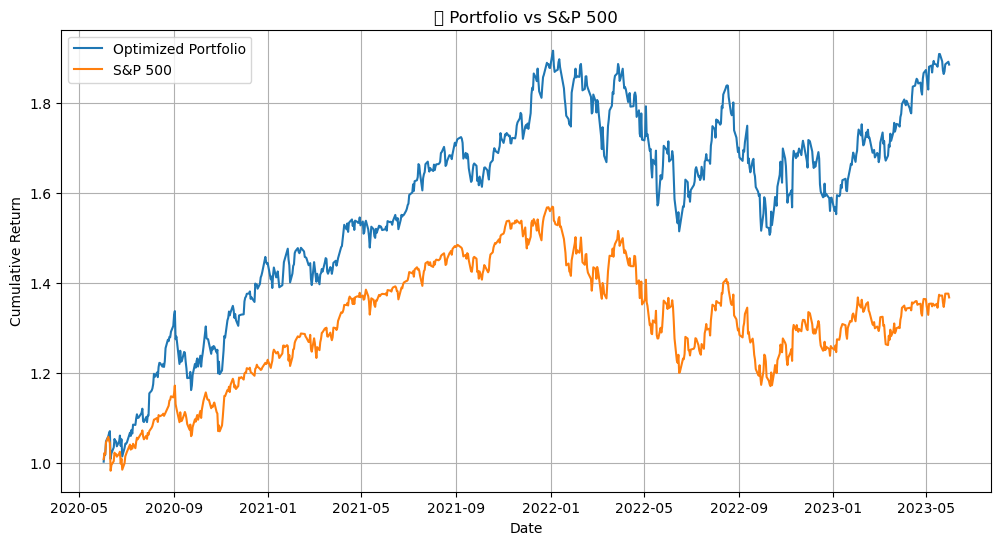

In [8]:
# Get S&P 500 data
benchmark = yf.download('^GSPC', start="2020-06-01", end="2023-06-01", auto_adjust=True)['Close']
benchmark_returns = benchmark.pct_change().dropna()
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Plot both
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.plot(benchmark_cum_returns, label='S&P 500')
plt.title('📊 Portfolio vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Calculate 5% historical VaR
var_95 = np.percentile(portfolio_returns, 5)

print(f"📉 Value at Risk (95% confidence): {var_95:.2%}")


📉 Value at Risk (95% confidence): -2.04%


In [10]:
from scipy.stats import norm

# Calculate mean and std deviation of daily portfolio returns
mean_return = portfolio_returns.mean()
std_dev = portfolio_returns.std()

# 1-day 95% Value at Risk
var_95 = norm.ppf(0.05, mean_return, std_dev)
var_10day = var_95 * np.sqrt(10)

print(f"🔻 1-Day VaR (95% confidence): {var_95:.2%}")
print(f"🔻 10-Day VaR (95% confidence): {var_10day:.2%}")

🔻 1-Day VaR (95% confidence): -2.14%
🔻 10-Day VaR (95% confidence): -6.78%
